<a href="https://colab.research.google.com/github/tomcaputo/aws_product_embeddings/blob/main/Product_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Product Embedddings with the Amazon 2023

TODO
- MLFlow logging
- test and train script
- How to update model with new users with transfer learning


## Retrieval - algorithm scales well: focused on recall
Supervised
- Matrix Factorization
- NCF
- Two Towers

Embed --> VectorDB --> Retrieve via similarity

## Reranker -- employ more sophisticed models: focused on precision
- Transformer
- XGBoost



## Dependencies

In [1]:
!pip install faiss-gpu
!pip install datasets #evaluate torch
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed.

In [2]:
import json

In [3]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import torch

from datasets import load_dataset

import faiss

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

from sklearn.preprocessing import LabelEncoder

In [4]:
sys.path.append("/content/drive/MyDrive/Colab Notebooks/RAG/")
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks/RAG/'

ValueError: mount failed

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

In [ ]:
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

### Load Data

In [ ]:

# Load interaction data
download_interaction_data = False
if download_interaction_data:
  interaction_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_Books", trust_remote_code=True)
  print(interaction_dataset["full"][0])
  interaction_dataset["full"].to_parquet(data_dir + 'amazon_2023_full.parquet')

create_downsmaple = False
if create_downsmaple:
  interaction_df = pd.read_parquet(data_dir + 'amazon_2023_full.parquet')
  downsample_frac = .005

  # identify downsample IDs
  user_ids = pd.Series(interaction_df['user_id']).unique()
  rand_ids = np.random.uniform(0, 1, len(user_ids))
  user_ids = pd.Series(user_ids[rand_ids < downsample_frac])

  # downsample
  interaction_df[interaction_df['user_id'].isin(user_ids)].to_parquet(data_dir + 'amazon_2023_downsampled.parquet')

interaction_df = pd.read_parquet(data_dir + 'amazon_2023_downsampled.parquet')


In [ ]:
interaction_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
2925,3.0,Not quite what I expected.,"It was nice, but not what I expected. I still ...",[],1338252801,1338252801,AH4FS5WFXP6G4REX7BSQFRLRLNZQ,1610585135448,0,True
6295,5.0,Great read!,"Great read. One for me, one as a gift. Friend ...",[],0060853964,0060853964,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1542813324549,0,True
6296,5.0,👍🏽,👍🏽,[],0761169083,0761169083,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1482324158000,0,True
6297,5.0,"Great condition, love this deck!",I love this deck of cards. I've bought it as g...,[],1561380792,1561380792,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1416085800000,1,True
6298,1.0,Boring!,Geez! What's all the hype about?? Absolutely n...,[],0345803485,0345803485,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1361917994000,2,True


In [ ]:
download_metadata = False
if download_metadata:
  metadata_dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_Books", trust_remote_code=True)
  print(metadata_dataset["full"][0])
  metadata_dataset["full"].to_parquet(data_dir + 'amazon_2023_metadata.parquet')

create_downsmaple = False
if create_downsmaple:
  metadata_df = pd.read_parquet(data_dir + 'amazon_2023_metadata.parquet')

  # identify downsample IDs
  item_ids = pd.Series(interaction_df['parent_asin']).unique()

  # downsample
  metadata_df[metadata_df['parent_asin'].isin(item_ids)].to_parquet(data_dir + 'amazon_2023_metadata_downsampled.parquet')

metadata_df = pd.read_parquet(data_dir + 'amazon_2023_metadata_downsampled.parquet')

In [ ]:
metadata_df.parent_asin.nunique()

113638

In [ ]:
print(f"""users: {interaction_df.user_id.nunique()}
      items: {interaction_df.asin.nunique()}""")

users: 51611
      items: 113753


In [ ]:
interaction_df.groupby('user_id')['asin'].count().value_counts().head()#.head().count().sort_values(ascending=True)

asin
1    29618
2     9441
3     4194
4     2393
5     1422
Name: count, dtype: int64

In [ ]:
interaction_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
2925,3.0,Not quite what I expected.,"It was nice, but not what I expected. I still ...",[],1338252801,1338252801,AH4FS5WFXP6G4REX7BSQFRLRLNZQ,1610585135448,0,True
6295,5.0,Great read!,"Great read. One for me, one as a gift. Friend ...",[],0060853964,0060853964,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1542813324549,0,True
6296,5.0,👍🏽,👍🏽,[],0761169083,0761169083,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1482324158000,0,True
6297,5.0,"Great condition, love this deck!",I love this deck of cards. I've bought it as g...,[],1561380792,1561380792,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1416085800000,1,True
6298,1.0,Boring!,Geez! What's all the hype about?? Absolutely n...,[],0345803485,0345803485,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1361917994000,2,True


In [ ]:
metadata_df.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
2,Books,Service: A Navy SEAL at War,4.7,3421,"[Marcus Luttrell, author of the #1 bestseller,...","[Review, Praise for SERVICE""An action-packed.....",17.17,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}","Marcus Luttrell (Author), James D. Hornfischer","[Books, Biographies & Memoirs, Leaders & Notab...","{""Publisher"": ""Little, Brown and Company; 1st ...",0316185361,None,"Hardcover – May 8, 2012",{'avatar': 'https://m.media-amazon.com/images/...
7,Books,Make: Electronics: Learning Through Discovery,4.7,1366,"[""This is teaching at its best!"", Hans Camenzi...","[From the Author, Make: Electronics, is the bo...",13.43,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Charles Platt (Author),"[Books, Engineering & Transportation, Engineer...","{""Publisher"": ""Make Community, LLC; 2nd editio...",1680450263,None,2nd Edition,{'avatar': 'https://m.media-amazon.com/images/...
51,Books,I Hadn't Meant to Tell You This,4.8,61,[Twelve-year-old Marie is a leader among the p...,"[Amazon.com Review, Two girls: one white, one ...",2.09,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Jacqueline Woodson (Author),"[Books, Children's Books, Geography & Cultures]","{""Publisher"": ""Laurel Leaf (November 1, 1995)""...",0440219604,None,"Mass Market Paperback – November 1, 1995",{'avatar': 'https://m.media-amazon.com/images/...
93,Books,"Modern Fishing Lure Collectibles, Vol. 3: Iden...",4.3,10,"[Like Volumes 1 and 2, Modern Fishing Lure Col...","[Review, The great variety of fishing lures wi...",22.25,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Russell E. Lewis (Author),"[Books, Crafts, Hobbies & Home, Antiques & Col...","{""Publisher"": ""Collector Books; First Edition ...",1574324225,None,"Hardcover – Illustrated, October 15, 2004",{'avatar': 'https://m.media-amazon.com/images/...
105,Books,Looking for Peyton Place: A Novel,4.4,976,[The death of her mother brings award-winning ...,"[From Publishers Weekly, With her mother decea...",9.63,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Barbara Delinsky (Author),"[Books, Literature & Fiction, Contemporary]","{""Publisher"": ""Scribner; First Edition (July 1...",0743246446,None,"Hardcover – July 12, 2005",{'avatar': 'https://m.media-amazon.com/images/...


## Feature Engineering

In [ ]:
metadata_df['price'] = metadata_df['price'].str.replace('[^0-9\.]', '', regex=True)\
                                .replace('', np.nan).astype(float)\
                                .fillna(0)



In [ ]:
features = ['average_rating', 'rating_number', 'price']

## Prepare Data for Modeling

In [ ]:
train_interactions = interaction_df.copy()
train_metadata = metadata_df.copy()

In [ ]:
user_encoder = LabelEncoder()
product_encoder = LabelEncoder()
parent_product_encoder = LabelEncoder()

train_interactions['user_id'] = user_encoder.fit_transform(train_interactions['user_id'])
train_interactions['asin'] = product_encoder.fit_transform(train_interactions['asin'])
train_metadata['parent_asin'] = parent_product_encoder.fit_transform(train_metadata['parent_asin'])
train_interactions['parent_asin'] = parent_product_encoder.transform(train_interactions['parent_asin'])

In [ ]:
item_metadata_tensor = torch.tensor(train_metadata[features].astype(float).values)

user_tensor = torch.tensor(train_interactions['user_id'].astype(int).values)
product_tensor = torch.tensor(train_interactions['asin'].astype(int).values)
rating_tensor = torch.tensor((train_interactions['rating'].values>=0).astype(float))
parent_idx_tensor = torch.tensor(train_interactions['parent_asin'].astype(int).values)

# Convert to torch sparse tensor
interaction_tensor = torch.sparse_coo_tensor(
    indices=torch.tensor(torch.stack([user_tensor, product_tensor])),
    values=torch.tensor(rating_tensor),
)

<ipython-input-52-43f6033b2352>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indices=torch.tensor(torch.stack([user_tensor, product_tensor])),
<ipython-input-52-43f6033b2352>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  values=torch.tensor(rating_tensor),


In [ ]:
class AmazonDataset(Dataset):

  def __init__(self, item_metadata, parent_idx_tensor, interaction_matrix):


    self.item_metadata = item_metadata
    self.interactions = interaction_matrix
    self.parent_idx = parent_idx_tensor
    self.values = self.interactions._values()
    self.indices = self.interactions._indices()


  def __len__(self):
    return self.values.size(0)

  def __getitem__(self, idx):

    # context
    user_idx = self.indices[0, idx]
    item_idx = self.indices[1, idx]

    parent_idx = self.parent_idx[idx]

    # interactions
    item_meta = self.item_metadata[parent_idx]

    # target
    rating = self.values[idx]

    return user_idx, item_idx, rating, item_meta

In [ ]:
az_dataset = AmazonDataset(item_metadata_tensor,
                           parent_idx_tensor,
                           interaction_tensor)

In [ ]:
az_dataset.__getitem__(1)

(tensor(23925),
 tensor(987),
 tensor(1., dtype=torch.float64),
 tensor([  4., 556.,   0.], dtype=torch.float64))

## Models

In [ ]:
class TwoTowerNCF(pl.LightningModule):

  def __init__(self, n_users, n_items,
               item_metadata_dim,
               embedding_size, metadata_embedding_size,
               layers=1):

    super().__init__()

    # user tower
    self.user_tower_embedding = nn.Embedding(n_users, embedding_size)
    #self.user_metadata = nn.Embedding(user_metadata_dim, metadata_embedding_size)
    #self.user_tower_output = nn.Linear(embedding_size + metadata_embedding_size, embedding_size)

    # item tower
    self.item_embedding = nn.Embedding(n_items, embedding_size)
    self.item_metadata = nn.Linear(item_metadata_dim, metadata_embedding_size)
    self.item_concat_embedding = nn.Linear(embedding_size + metadata_embedding_size, embedding_size)

    self.user_tower_fc_layers = []
    self.item_tower_fc_layers = []

    input_dims = [embedding_size // i for i in range(1, layers+1)]
    output_dims = [embedding_size // (i+1) for i in range(1, layers+1)]

    for i in range(layers):
      self.user_tower_fc_layers.append(nn.Linear(input_dims[i], output_dims[i]))
      self.item_tower_fc_layers.append(nn.Linear(input_dims[i], output_dims[i]))

      self.user_tower_fc_layers.append(nn.BatchNorm1d(output_dims[i]))
      self.item_tower_fc_layers.append(nn.BatchNorm1d(output_dims[i]))

      self.user_tower_fc_layers.append(nn.ReLU())
      self.item_tower_fc_layers.append(nn.ReLU())


    self.user_tower_fc_layers = nn.Sequential(*self.user_tower_fc_layers)
    self.item_tower_fc_layers = nn.Sequential(*self.item_tower_fc_layers)

  def forward(self, user_idx, product_idx, item_meta, target):

    # user tower base
    user_x = self.user_tower_embedding(user_idx)
    user_x = F.relu(user_x)


    # item tower base
    item_x = self.item_embedding(product_idx)
    item_meta_x = self.item_metadata(item_meta.float())
    item_x = torch.cat([item_x, item_meta_x], dim=1)
    item_x = self.item_concat_embedding(item_x)
    item_x = F.relu(item_x)

    # tower layers
    item_x = self.item_tower_fc_layers(item_x)
    user_x = self.user_tower_fc_layers(user_x)

    # cosine similarity
    output = F.cosine_similarity(item_x, user_x)
    output = torch.sigmoid(output)

    return output

  def training_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log_dict({'train_loss': loss}, prog_bar=True, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log('val_loss', loss)
    return loss

  def common_step(self, batch, batch_idx):
    user_idx, product_idx, rating, item_meta = batch
    output = self.forward(user_idx, product_idx, item_meta, rating)
    loss = F.binary_cross_entropy(output, rating.float())
    return loss

  def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=.001)



In [ ]:
import copy

In [ ]:
class SaveMetricsCallback(pl.Callback):

    def __init__(self):
      super().__init__()
      self.metrics = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the logs directly from the logger
        each_me = copy.deepcopy(trainer.callback_metrics['train_loss']).cpu().numpy()
        self.metrics.append(each_me)
        print(f"Epoch {trainer.current_epoch}: {trainer.callback_metrics}")


In [ ]:
callback = SaveMetricsCallback()
trainer = pl.Trainer(max_epochs=10, callbacks=[callback])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
n_items = interaction_df.asin.nunique()
n_users = interaction_df.user_id.nunique()
item_metadata_dim = item_metadata_tensor.size(1)
embedding_size = 16

train_loader = DataLoader(az_dataset, batch_size=1024, shuffle=True)

two_tower_model = TwoTowerNCF(n_users, n_items,
               item_metadata_dim,
               embedding_size, item_metadata_dim,
               layers=3)

trainer.fit(two_tower_model, train_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type       | Params | Mode 
-------------------------------------------------------------
0 | user_tower_embedding  | Embedding  | 825 K  | train
1 | item_embedding        | Embedding  | 1.8 M  | train
2 | item_metadata         | Linear     | 12     | train
3 | item_concat_embedding | Linear     | 320    | train
4 | user_tower_fc_layers  | Sequential | 239    | train
5 | item_tower_fc_layers  | Sequential | 239    | train
-------------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.587    Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytor

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0: {'train_loss': tensor(0.5007, device='cuda:0'), 'train_loss_step': tensor(0.4605, device='cuda:0'), 'train_loss_epoch': tensor(0.5007, device='cuda:0')}
Epoch 1: {'train_loss': tensor(0.4422, device='cuda:0'), 'train_loss_step': tensor(0.4274, device='cuda:0'), 'train_loss_epoch': tensor(0.4422, device='cuda:0')}
Epoch 2: {'train_loss': tensor(0.4166, device='cuda:0'), 'train_loss_step': tensor(0.4160, device='cuda:0'), 'train_loss_epoch': tensor(0.4166, device='cuda:0')}
Epoch 3: {'train_loss': tensor(0.4001, device='cuda:0'), 'train_loss_step': tensor(0.4040, device='cuda:0'), 'train_loss_epoch': tensor(0.4001, device='cuda:0')}
Epoch 4: {'train_loss': tensor(0.3854, device='cuda:0'), 'train_loss_step': tensor(0.3772, device='cuda:0'), 'train_loss_epoch': tensor(0.3854, device='cuda:0')}
Epoch 5: {'train_loss': tensor(0.3716, device='cuda:0'), 'train_loss_step': tensor(0.3724, device='cuda:0'), 'train_loss_epoch': tensor(0.3716, device='cuda:0')}
Epoch 6: {'train_loss': tens

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: {'train_loss': tensor(0.3499, device='cuda:0'), 'train_loss_step': tensor(0.3550, device='cuda:0'), 'train_loss_epoch': tensor(0.3499, device='cuda:0')}


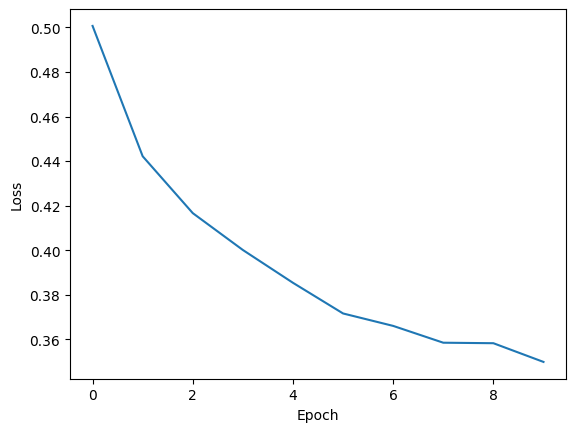

In [ ]:
plt.plot(np.array(callback.metrics))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Sequential Model

In [ ]:
#interaction_df.sort_values('timestmap', ascending=False).groupby('user_id')['rating'].apply(lambda x: x)

In [ ]:
interaction_df

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
2925,3.0,Not quite what I expected.,"It was nice, but not what I expected. I still ...",[],1338252801,1338252801,AH4FS5WFXP6G4REX7BSQFRLRLNZQ,1610585135448,0,True
6295,5.0,Great read!,"Great read. One for me, one as a gift. Friend ...",[],0060853964,0060853964,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1542813324549,0,True
6296,5.0,👍🏽,👍🏽,[],0761169083,0761169083,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1482324158000,0,True
6297,5.0,"Great condition, love this deck!",I love this deck of cards. I've bought it as g...,[],1561380792,1561380792,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1416085800000,1,True
6298,1.0,Boring!,Geez! What's all the hype about?? Absolutely n...,[],0345803485,0345803485,AFVFLOD4M7Y3LOVDOYOC4IL34XQQ,1361917994000,2,True
...,...,...,...,...,...,...,...,...,...,...
29474574,5.0,Daughter loved it,My daughter hugged the books on Christmas morn...,[],1454903597,1454903597,AF4K4X523XERW6VAM7TONCFJXTZQ,1388592808000,0,True
29474605,5.0,Oh Brothers!,Another terrific tale from Robert Ferrigno. N...,[],0375401253,0375401253,AF66SYN54HL2HK5T3JWPF4G4ZLVQ,1012375362000,0,False
29474606,4.0,Bourne again?,I enjoyed this book. Partially because it was...,[],0385479611,0385479611,AF66SYN54HL2HK5T3JWPF4G4ZLVQ,1012374866000,2,False
29474710,5.0,Five Stars,Fun class,[],1449697208,1449697208,AHHXPDYK3IVYF3ALMXZQT2VPSGZQ,1431893209000,0,True


In [ ]:
class PlTrainer(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.criterion = F.binary_cross_entropy

  def configure_callbacks(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=.001)
    return optimizer

  def common_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x, causal=True)

    y_hat = y_hat.reshape((len(y_hat)*y_hat.shape[1], y_hat.shape[-1]))
    y = y.reshape((len(y)*y.shape[1], y.shape[-1]))
    ind = x['strt_ind'].view(-1) == True

    y_hat = y_hat[ind]
    y = y[ind]

    y_hat = y_hat[:, 1:]
    y = y[:, 1:]

    loss = self.criterion(y_hat, y)

    return loss

  def training_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
    return loss

  def validation_step(self, batch, batch_idx):
    loss = self.common_step(batch, batch_idx)
    self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True, on_step=False)
    return loss

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int,
                  droupout: float=.1, max_len: int=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        self.register_buffer('pe', pe) # registers for as part of model state, nontrainable parameter

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [ ]:
class TabTransformer(pl.LightningModule):
  def __init__(self, num_items, d_model, nhead,
               num_encoder_layers, dim_feedforward,
               max_len, dropout=0.1):
    self.d_model = d_model
    self.contextual_embedding = nn.TransformerEncoderLayer(
        d_model, nhead, dim_feedforward, dropout
    )

  def forward(self, x: list):
    xs = []
    b,t,c, = x[0].shape

    for feature in x:
      xs.append(feature.reshape((b*t, 1, c)))

    xs = torch.concatenate(xs, dim=1)
    xs = self.contextual_embedding(xs)
    xs = xs.reshape((b, t, c*len(x)))
    return xs

In [ ]:
class TransformerModel(PlTrainer):
  # embed seperately, then layer norm, # more dim for contexxtual dim,
  # multiple laters for self attention, layernorm, a couple linear layers to shrink size to final output


  def __init__(self, num_items, d_model, nhead,
                num_encoder_layers, dim_feedforward,
                max_len, dropout=0.1):
      super().__init__()
      self.item_embedding = nn.Embedding(num_items, d_model)
      self.position_embedding = PositionalEncoding(d_model, max_len)
      self.transformer_encoder = nn.TransformerEncoder(
          nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout),
          num_encoder_layers
      )
      self.norm = nn.LayerNorm(d_model)
      self.linear = nn.Linear(d_model, num_items)
      self.dropout = nn.Dropout(dropout)
      self.d_model = d_model

  @classmethod
  def from_pretrained(cls, PATH):

    params = json.load(open(PATH + '/params.json', 'r'))
    model = cls(**params)
    model.load_state_dict(torch.load(PATH+ '/model.json'))
    model.__dict__.update(params)
    model.params.update(params)
    return model

  def forward(self, src, src_mask):
      src = self.item_embedding(src) * np.sqrt(self.d_model)
      src = self.position_embedding(src)
      output = self.transformer_encoder(src)
      output = self.linear(output)


      # embedding layers
      self.norm(self.apex(src['apex']))

      # seasonal embeddings
      torch.sin(2*3.14*src['dow']/7)
      torch.cos(2*3.14*src['dow']/7)

      seasonal_embed = torch.cat([...])
      self.norm(self.seasonal_embed(seasonal_em))

      # SASRec
      item_em = self.product_embedding(src['seq'][:, :, -1]) #3d to 2D token embeddings
      item_em = self.prod_encoder(item_em) + seasonal_em
      item_encoded = self.item_encoder(item_em, src_mask=src_mask)


      item_encoded = self.item_encoder(item_em, src_mask=src_mask) + item_em # why add this back in?

      ft_em = self.contextual_em([...])
      output = self.norm(ft_em)
      output = self.linear(output)

      return output

  def save(self, PATH=None):
    """
    Save model to PATH
    """

    if not os.path.exists(PATH):
      os.makedirs(PATH)

    torch.save(self.state_dict(), PATH + '/model.json')
    params = {}

    for key, value in self.__dict__.items():
      if type(value) in (type('s'), type(1), type(1.)):
        params.update({key:value})
    json.dump(params, open(PATH + '/params.json', 'w'))
    self.params.updates(params)